# Window-Based Detection using KAZE Descriptor Featuring Matching

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [221]:
# Global Variables
curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '000.jpg')
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')

# File path for BOVW
bovw_file_path = os.path.join(curr_wd, 'models/')
bovw_file_path_waldo = os.path.join(bovw_file_path, 'waldo/')
bovw_kaze_file_path = os.path.join(bovw_file_path_waldo, 'bovw_kaze_50.pkl')
bovw_sift_file_path = os.path.join(bovw_file_path_waldo, 'bovw_sift_50.pkl')
bovw_brisk_file_path = os.path.join(bovw_file_path_waldo, 'bovw_brisk_50.pkl')

# Descriptor type to use
desc_type = 'kaze'

with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)

### Load Dataset

Loads the patches from the `datasets/train/positives` and `datasets/train/extra` as training data for classifier model. The patches are in the type `ndarray`
<br> *Detection classes allowed:* </br>
- **waldo_face_front** </br>
- **waldo_face_side** </br>
- **waldo_body_full** </br>
- **waldo_body_half** </br>
- **wenda_face_front** </br>
- **wenda_body_full** </br>
- **wenda_body_half** </br>
- **wizard_face_front** </br>
- **wizard_body_full** </br>
- **wizard_body_half** </br>
- **other_face_front** </br>
- **other_body_full** </br>
- **other_body_half**</br>

In [3]:
# Load data from all poses for current detection class
detection_class = 'waldo'
face_front = detection_class + '_face_front'
face_side = detection_class + '_face_side'
body_full = detection_class + '_body_full'
body_half = detection_class + '_body_half'

# Load data for front face
print('Loading data for front face')
detection_type = [face_front]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_ff, valid_instances_ff = list(train_loader), list(valid_loader)

# Load data for side face
print('Loading data for side face')
detection_type = [face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_sf, valid_instances_sf = list(train_loader), list(valid_loader)

# Load data for full body
print('Loading data for full body')
detection_type = [body_full]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bf, valid_instances_bf = list(train_loader), list(valid_loader)

# Load data for half body
print('Loading data for half body')
detection_type = [body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bh, valid_instances_bh = list(train_loader), list(valid_loader)

# Load data for all faces
print('Loading data for all faces')
detection_type = [face_front, face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_f, valid_instances_f = list(train_loader), list(valid_loader)

# Load data for all body
print('Loading data for all bodies')
detection_type = [body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_b, valid_instances_b = list(train_loader), list(valid_loader)

# Load data for all examples
print('Loading all training examples')
detection_type = [face_front, face_side, body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_all, valid_instances_all = list(train_loader), list(valid_loader)

Loading data for front face
---num of training instances: 1632
---num of validation instances: 408
Loading data for side face
---num of training instances: 1424
---num of validation instances: 356
Loading data for full body
---num of training instances: 1436
---num of validation instances: 358
Loading data for half body
---num of training instances: 1424
---num of validation instances: 356
Loading data for all faces
---num of training instances: 1668
---num of validation instances: 416
Loading data for all bodies
---num of training instances: 2860
---num of validation instances: 714
Loading all training examples
---num of training instances: 4527
---num of validation instances: 1131


In [4]:
# Split the data into training examples and labels
train_ff_x, train_ff_y = extract_data(train_instances_ff)
train_sf_x, train_sf_y = extract_data(train_instances_sf)
train_bf_x, train_bf_y = extract_data(train_instances_bf)
train_bh_x, train_bh_y = extract_data(train_instances_bh)
train_f_x, train_f_y = extract_data(train_instances_f)
train_b_x, train_b_y = extract_data(train_instances_b)
train_all_x, train_all_y = extract_data(train_instances_all)

In [28]:
# Split the data into validation examples and labels
val_ff_x, val_ff_y = extract_data(valid_instances_ff)
val_sf_x, val_sf_y = extract_data(valid_instances_sf)
val_bf_x, val_bf_y = extract_data(valid_instances_bf)
val_bh_x, val_bh_y = extract_data(valid_instances_bh)
val_f_x, val_f_y = extract_data(valid_instances_f)
val_b_x, val_b_y = extract_data(valid_instances_b)
val_all_x, val_all_y = extract_data(valid_instances_all)

In [12]:
# Extract feature descriptors from entire training set
# Compute cluster centers to be used as bag of words
if os.path.isfile(bovw_kaze_file_path):
    with open(bovw_kaze_file_path, 'rb') as f:
        bag_of_words_kaze = pickle.load(f)
else:
    train_features_kaze = extract_features(train_all_x, desc_type='kaze')
    bag_of_words_kaze = cluster_features(train_features_kaze)
print('Number of KAZE descriptors:', len(train_features_kaze))

if os.path.isfile(bovw_sift_file_path):
    with open(bovw_sift_file_path, 'rb') as f:
        bag_of_words_sift = pickle.load(f)
else:
    train_features_sift = extract_features(train_all_x, desc_type='sift')
    bag_of_words_sift = cluster_features(train_features_sift)
print('Number of SIFT descriptors:', len(train_features_sift))

if os.path.isfile(bovw_brisk_file_path):
    with open(bovw_brisk_file_path, 'rb') as f:
        bag_of_words_brisk = pickle.load(f)
else:
    train_features_brisk = extract_features(train_all_x, desc_type='brisk')
    bag_of_words_brisk = cluster_features(train_features_brisk)
print('Number of BRISK descriptors:', len(train_features_brisk))

Number of KAZE descriptors: 360783
Number of SIFT descriptors: 1028554
Number of BRISK descriptors: 1124792


### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

#### Classifier for Front Face

In [188]:
# Generate classifiers for front face
svm_linear_ff, svm_rbf_ff, gbc_ff, rf_ff = generate_models(train_ff_x, train_ff_y, val_ff_x, val_ff_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.852
Recall: 0.719
F1 Score: 0.780


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.911
Recall: 0.797
F1 Score: 0.850
Performance of RandomForestClassifier on validation set:
Precision: 0.902
Recall: 0.578
F1 Score: 0.705


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for Side Face

In [189]:
# Generate classifiers for side face
svm_linear_sf, svm_rbf_sf, gbc_sf, rf_sf = generate_models(train_sf_x, train_sf_y, val_sf_x, val_sf_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 0.667
Recall: 0.400
F1 Score: 0.500
Performance of RandomForestClassifier on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Classifier for Full Body

In [190]:
# Generate classifiers for full body
svm_linear_bf, svm_rbf_bf, gbc_bf, rf_bf = generate_models(train_bf_x, train_bf_y, val_bf_x, val_bf_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.667
F1 Score: 0.800
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.333
F1 Score: 0.500


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for Half Body

In [191]:
# Generate classifiers for half body
svm_linear_bh, svm_rbf_bh, gbc_bh, rf_bh = generate_models(train_bh_x, train_bh_y, val_bh_x, val_bh_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'pre

Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.250
F1 Score: 0.400
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.167
F1 Score: 0.286


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for All Faces

In [192]:
# Generate classifiers for all faces
svm_linear_f, svm_rbf_f, gbc_f, rf_f = generate_models(train_f_x, train_f_y, val_f_x, val_f_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.862
Recall: 0.781
F1 Score: 0.820


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.855
Recall: 0.828
F1 Score: 0.841
Performance of RandomForestClassifier on validation set:
Precision: 0.870
Recall: 0.625
F1 Score: 0.727


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for all body poses

In [193]:
# Generate classifiers for all body poses
svm_linear_b, svm_rbf_b, gbc_b, rf_b = generate_models(train_b_x, train_b_y, val_b_x, val_b_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.846
Recall: 0.647
F1 Score: 0.733
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.471
F1 Score: 0.640


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Classifier for entire training data

In [194]:
# Generate classifiers for front face
svm_linear_all, svm_rbf_all, gbc_all, rf_all = generate_models(train_all_x, train_all_y, val_all_x, val_all_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.879
Recall: 0.377
F1 Score: 0.527


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.847
Recall: 0.649
F1 Score: 0.735
Performance of RandomForestClassifier on validation set:
Precision: 0.886
Recall: 0.403
F1 Score: 0.554


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

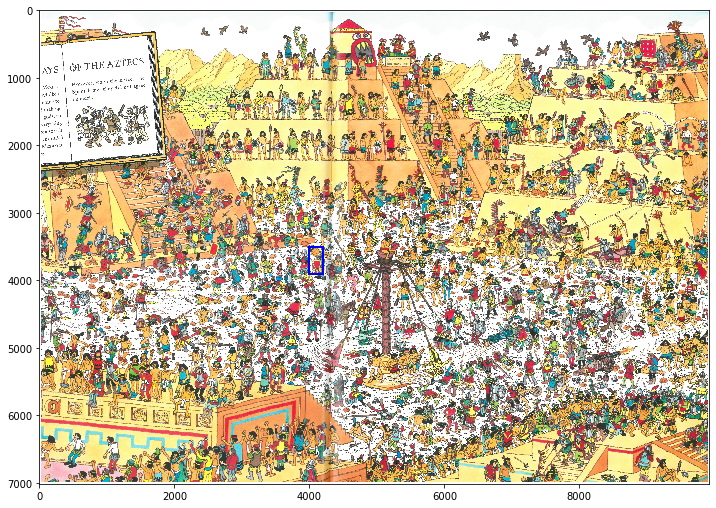

In [222]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)

window_size = (200, 400)
step_size = 500

example_full = plt.imread(example_full_path)
ax.imshow(example_full)

rect = patches.Rectangle((4000, 3500), window_size[0], window_size[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

In [133]:
stacked_classifiers = [
    svm_linear_ff, svm_rbf_ff, gbc_ff, rf_ff # Front Face Classifiers
#     gbc_sf, rf_sf, # Side Face Classifiers
#     gbc_bf, rf_bf, # Full Body Classifiers
#     gbc_bh, rf_bh, # Half Body Classifiers
#     gbc_f, rf_f, # All Face Classifiers
#     gbc_b, rf_b, # All Body Classifiers
#     gbc_all, rf_all # All Classifier
]

feature_vector = extract_histograms([train_ff_x[18]], bag_of_words_sift, desc_type='sift')

In [229]:
# Perform detection
detections = detect(example_full, bag_of_words_kaze, stacked_classifiers, desc_type=desc_type)
print('Number of Bounding Boxes: ', len(detections))

Number of Bounding Boxes:  21


In [230]:
ground_truth = [0] * 4
for box in provided_annots['000.jpg']:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

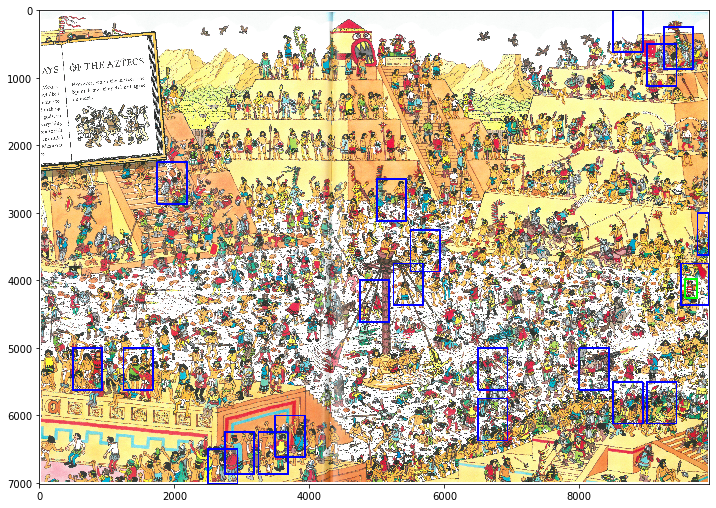

In [231]:
# Visualise detections
clone = example_full.copy()
for (x1, y1, x2, y2, score) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)